<a href="https://colab.research.google.com/github/giacomominello/AI4S/blob/master/AI4S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARTIFICIAL INTELLIGENCE FOR SECURITY - Assignment: Android Malware detection

![AI](https://media.giphy.com/media/l4pTsNgkamxfk2ZLq/giphy.gif "AI")

Group: 

Note that there are 2 CSV files, one contains the data and the other provides a mapping of features to categories.

##Try doing some visualisation and analysis of the data.


In [0]:
import pandas as pd #https://pandas.pydata.org/pandas-docs/stable/index.html
import numpy as np #https://numpy.org/devdocs/ 
import time 
import seaborn as sns
import matplotlib.pyplot as plt #https://matplotlib.org/api/pyplot_api.html
from ipywidgets import widgets #https://ipywidgets.readthedocs.io/en/latest/
from ipywidgets import interact #"It's a surprise tool that will help us later" 
%load_ext google.colab.data_table
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import check_random_state
random_state = np.random.RandomState(42) #should allow us to have deterministic results (up to roundoff error)

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1VfFHOYO3gK9FzkEwOoW8B82wFiG9vMMS'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('drebin-215-dataset-5560malware-9476-benign.csv')  
df = pd.read_csv('drebin-215-dataset-5560malware-9476-benign.csv')

file_id = '1ES9OdZ9F5LLo1F46PtYt6AePsh92O07C'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('dataset-features-categories.csv')  
feature_mapping = pd.read_csv('dataset-features-categories.csv',header=None)

df.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,Ljava.net.URLDecoder,android.content.pm.Signature,android.telephony.SmsManager,READ_PHONE_STATE,getBinder,ClassLoader,Landroid.content.Context.registerReceiver,Ljava.lang.Class.getField,Landroid.content.Context.unregisterReceiver,GET_ACCOUNTS,RECEIVE_SMS,Ljava.lang.Class.getDeclaredField,READ_SMS,getCallingUid,Ljavax.crypto.spec.SecretKeySpec,android.intent.action.BOOT_COMPLETED,USE_CREDENTIALS,MANAGE_ACCOUNTS,android.content.pm.PackageInfo,KeySpec,TelephonyManager.getLine1Number,DexClassLoader,HttpGet.init,SecretKey,Ljava.lang.Class.getMethod,System.loadLibrary,android.intent.action.SEND,Ljavax.crypto.Cipher,WRITE_SMS,READ_SYNC_SETTINGS,...,BIND_TEXT_SERVICE,INSTALL_LOCATION_PROVIDER,android.intent.action.CALL_BUTTON,android.intent.action.SCREEN_OFF,findClass,SYSTEM_ALERT_WINDOW,MOUNT_FORMAT_FILESYSTEMS,CHANGE_CONFIGURATION,CLEAR_APP_USER_DATA,intent.action.RUN,android.intent.action.SET_WALLPAPER,CHANGE_WIFI_STATE,READ_FRAME_BUFFER,ACCESS_SURFACE_FLINGER,Runtime.loadLibrary,BROADCAST_SMS,EXPAND_STATUS_BAR,INTERNAL_SYSTEM_WINDOW,android.intent.action.BATTERY_LOW,SET_ACTIVITY_WATCHER,WRITE_CONTACTS,android.intent.action.ACTION_POWER_CONNECTED,BIND_VPN_SERVICE,DISABLE_KEYGUARD,ACCESS_MOCK_LOCATION,GET_PACKAGE_SIZE,MODIFY_PHONE_STATE,CHANGE_COMPONENT_ENABLED_STATE,CLEAR_APP_CACHE,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,S
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,1,0,0,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,S
6,0,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,S
7,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,S
8,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,S
9,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,S


In [0]:
df=df.drop(['TelephonyManager.getSimCountryIso'],axis=1) #ok we should drop just the line but it's ok anyway


In [0]:
feature_mapping=feature_mapping.drop(index=92)

- What types of features look most predictive of the class?


In [0]:
#idk, let's see it with a tree

elapsed time = 0.20
accuracy: 0.9737367021276596
precision: 0.971113
recall: 0.972667
              precision    recall  f1-score   support

           B       0.98      0.98      0.98      1895
           S       0.96      0.97      0.96      1113

    accuracy                           0.97      3008
   macro avg       0.97      0.97      0.97      3008
weighted avg       0.97      0.97      0.97      3008



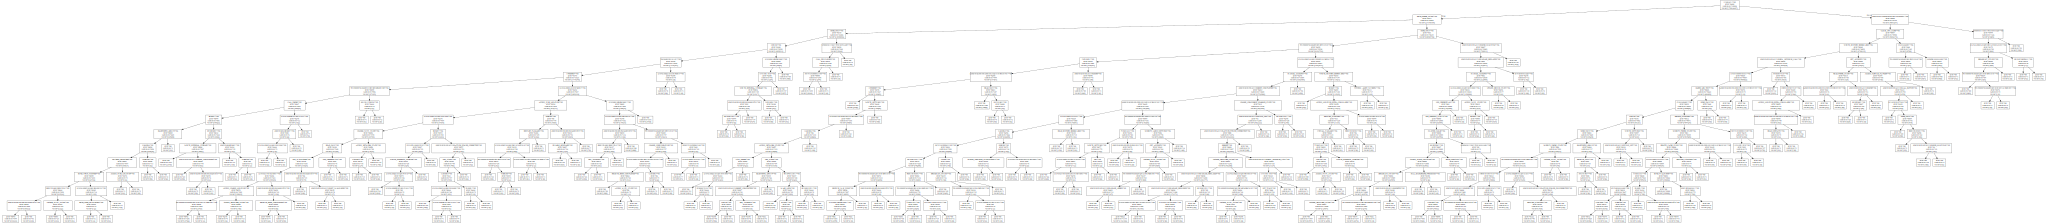

In [0]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(
    df.drop(['class'],axis=1),
    df[['class']], 
    test_size=0.20
)

!pip install graphviz
import graphviz
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
# define the classifier
clf_dt = DecisionTreeClassifier(criterion='gini' ,max_depth=15)

# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))

# perform the prediction
y_pred_dt = clf_dt.predict(X_test)

print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))

# visual tree
from sklearn import tree
graphviz.Source(export_graphviz(clf_dt, 
                                out_file=None,
                                feature_names=list(X_train.columns.values)))

In [0]:
sorted(zip(clf_dt.feature_importances_,df.columns ),reverse=True)

[(0.3334517595668907, 'transact'),
 (0.20850121379043632, 'READ_PHONE_STATE'),
 (0.09839718308183822, 'SEND_SMS'),
 (0.04789969892419555, 'TelephonyManager.getDeviceId'),
 (0.019500414890805385, 'Ljava.lang.Class.getCanonicalName'),
 (0.017958851479674624, 'android.telephony.gsm.SmsManager'),
 (0.014605131628918203, 'android.intent.action.SEND_MULTIPLE'),
 (0.013539677786398195, 'MANAGE_ACCOUNTS'),
 (0.01242585877299407, 'ClassLoader'),
 (0.01173238928708319, 'Landroid.content.Context.registerReceiver'),
 (0.010853003044202678, 'android.intent.action.BOOT_COMPLETED'),
 (0.00974951336519676, 'remount'),
 (0.008641859550399218, 'chmod'),
 (0.008517741160105114, 'sendMultipartTextMessage'),
 (0.007919654899958375, 'GET_ACCOUNTS'),
 (0.007292430029652463, 'CLEAR_APP_CACHE'),
 (0.007046978438295132, 'WRITE_HISTORY_BOOKMARKS'),
 (0.006486682429356237, 'CHANGE_COMPONENT_ENABLED_STATE'),
 (0.006197482148309482, 'Ljava.net.URLDecoder'),
 (0.005322717618328128, 'android.content.pm.PackageInfo'),

- Train some classifiers to identify the malware. How well do they perform?


In [0]:
#we saw it with the tree, not so bad

- The second CSV file in the directory contains a mapping from features to categories (“API call signature”, “Intent”, “Manifest Permission”, etc.).


In [0]:
feature_mapping=feature_mapping.drop(index=215)
feature_mapping

,0,1
0,transact,API call signature
1,onServiceConnected,API call signature
2,bindService,API call signature
3,attachInterface,API call signature
4,ServiceConnection,API call signature
...,...,...
210,WRITE_EXTERNAL_STORAGE,Manifest Permission
211,ACCESS_FINE_LOCATION,Manifest Permission
212,SET_WALLPAPER_HINTS,Manifest Permission
213,SET_PREFERRED_APPLICATIONS,Manifest Permission


In [0]:
feature_mapping[1].unique()

array(['API call signature', 'Manifest Permission', 'Intent',
       'Commands signature'], dtype=object)

- It would be interesting to know which categories of features are most important for making good
predictions. Use the mapping to select only features of a particular category and train the model
on each category of features separately to understand which of the feature categories is most
important.


In [0]:
f1 = feature_mapping[feature_mapping[1] == 'API call signature'][0]
f2 = feature_mapping[feature_mapping[1] == 'Manifest Permission'][0]
f3 = feature_mapping[feature_mapping[1] == 'Intent'][0] 
f4 = feature_mapping[feature_mapping[1] == 'Commands signature'][0]

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# define the classifier
clf_dt = DecisionTreeClassifier()

print('API call signature')
X_train,  X_test, y_train, y_test = train_test_split(
    df[f1],
    df[['class']], 
    test_size=0.20
)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))
print(sorted(zip(clf_dt.feature_importances_,f1 ),reverse=True))

print('Manifest Permission')
X_train,  X_test, y_train, y_test = train_test_split(
    df[f2],
    df[['class']], 
    test_size=0.20
)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))
print(sorted(zip(clf_dt.feature_importances_,f2 ),reverse=True))

print('Intent')
X_train,  X_test, y_train, y_test = train_test_split(
    df[f3],
    df[['class']], 
    test_size=0.20
)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))
print(sorted(zip(clf_dt.feature_importances_,f3 ),reverse=True))

print('Commands signature')
X_train,  X_test, y_train, y_test = train_test_split(
    df[f4],
    df[['class']], 
    test_size=0.20
)
# train the classifier
t0 = time.time()
clf_dt.fit(X_train, y_train)
print("elapsed time = %.2f" % (time.time()-t0))
# perform the prediction
y_pred_dt = clf_dt.predict(X_test)
print("accuracy: {}".format(metrics.accuracy_score(y_test, y_pred_dt)))
print("precision: {:g}".format(metrics.precision_score(y_test, y_pred_dt, average='macro')))
print("recall: {:g}".format(metrics.recall_score(y_test, y_pred_dt, average='macro')))
print(metrics.classification_report(y_test, y_pred_dt))
print(sorted(zip(clf_dt.feature_importances_,f4 ),reverse=True))

API call signature
elapsed time = 0.07
accuracy: 0.9694148936170213
precision: 0.967364
recall: 0.967364
              precision    recall  f1-score   support

           B       0.98      0.98      0.98      1881
           S       0.96      0.96      0.96      1127

    accuracy                           0.97      3008
   macro avg       0.97      0.97      0.97      3008
weighted avg       0.97      0.97      0.97      3008

[(0.33387523468106534, 'transact'), (0.13129861719004127, 'TelephonyManager.getDeviceId'), (0.12057663794626416, 'android.telephony.SmsManager'), (0.04233355198520945, 'Ljava.lang.Class.getMethods'), (0.042185992454206615, 'android.telephony.gsm.SmsManager'), (0.03330042286405988, 'SET_ALARM'), (0.024607977074951274, 'ClassLoader'), (0.020583725567233018, 'TelephonyManager.getLine1Number'), (0.019199281367350066, 'Ljava.net.URLDecoder'), (0.01802837709015193, 'createSubprocess'), (0.014811228767647214, 'Ljava.lang.Object.getClass'), (0.01396515928290018, 'HttpGe

- Try doing some feature selection to find the subset of features (say 10) that are most important.


Dimension reduction techniques work by first creating a new set of dimensions/axes and _projecting_ the data to the new space. The process of projecting is a matrix multiplication,

$$ X' = XP,$$

where $X$ is the matrix of our original data, $n$ observations and $p$ columns/features, $X'$ is the matrix of our data in the new space, and $P$ is the matrix that projects our data onto the new feature space. $P$ has $p$ rows and $p$ columns where each column is a vector that represents a new dimension. The vectors are ordered from most important to least important with regards to capturing the variation in the data. If we only include the first $m$ columns of $P$, then the matrix multiplication will project our data onto a lower dimensional space. The matrix multiplication of an $n$ by $p$ matrix with a $p$ and $m$ matrix will result in a $n$ by $m$ matrix; our transformed data set has less features,

$$ X' = X \tilde{P}, $$

where $\tilde{P}$ is the truncated form of $P$ that has $m$ columns where $m < p$. The dimension reduction algorithms work by finding $P$ given an objective function. The objective function is typically constructing the projection matrix $P$ such that using the truncated form $\tilde{P}$ can still retain the majority of the information in our data set.

Principal component analysis (PCA) is a dimension reduction technique that takes a data set characterized by a set of possibly correlated features and generates a new set of features that are uncorrelated. It is used as a dimension reduction technique because the new set of uncorrelated features are chosen to be efficient in terms of capturing the variance in the data set.

## Implementation details of PCA

We have not discussed exactly how PCA obtains the new features. The matrix $\tilde{P}$ is chosen such that 

$$ \| X_c - X'\tilde{P}^T \|_2 $$

is minimized. The subscript $c$ refers to the centered data set. The product $X'\tilde{P}^T$ is the reconstruction of our data onto the original feature space. There are several algorithms to solve for the principal components but a popular one involves applying singular value decomposition. Singular value decomposition (SVD) is an algorithm to decompose a matrix into a product of three matrices,

$$ X_c = U \Sigma P^T. $$

You can envision that the matrix $X_c$ represents a transformation that can be broken into three steps: an initial rotation $P^T$, a scaling $\Sigma$, and a final rotation $U$. By applying SVD on $X_c$, the matrix $P$ is solved. The matrix $\Sigma$ is a diagonal matrix, a matrix with non-zero values along the diagonal, 

$$ \Sigma = \left[ \begin{array}{ccc} 
\sigma_1 & \\
& \sigma_2 & \\
&& \ddots & \\
&&&
\end{array} \right]$$

The diagonal values are ordered such that $|\sigma_1| \ge |\sigma_2| \ge \cdots |\sigma_{p-1}| \ge |\sigma_p|$. The larger the absolute value of $\sigma$, the greater amount of variation exists in that direction/component. Thus, to generate $\tilde{P}$ to truncate the data set, the first $m$ components/columns of $P$ are kept.

In scikit-learn, dimension reduction algorithms are transformers. The choice of having these algorithms as transformers makes sense since they apply a transformation on the data set. Let's illustrate the syntax for the PCA algorithm in scikit-learn. Note, other dimension reduction techniques in scikit-learn will have the same interface. For most of these algorithms, the data needs to be centered and scaled to work properly. PCA automatically centers the data but does not scale it. StandardScaler is often used for preprocessing the data prior to applying PCA.

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(['class'],axis=1))
pca = PCA(n_components=10)
dft = pca.fit_transform(df_scaled)

print("number of dimension before reduction: {}".format(df_scaled.shape[-1]))
print("number of dimension after reduction: {}".format(dft.shape[-1]))

print("explained variance ratio: {}".format(pca.explained_variance_ratio_))
print("cumulative explained variance ratio: {}".format(np.cumsum(pca.explained_variance_ratio_)[-1]))

print("retained variance: {}".format(pca.inverse_transform(dft).var()))

pd.DataFrame(pca.components_,columns=df.drop(['class'],axis=1).columns,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10'])

number of dimension before reduction: 214
number of dimension after reduction: 10
explained variance ratio: [0.11386321 0.05156524 0.03398418 0.02219616 0.02143451 0.01919158
 0.01874429 0.0170237  0.01600169 0.01576615]
cumulative explained variance ratio: 0.32977070262242386
retained variance: 0.32977070262242353


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,Ljava.net.URLDecoder,android.content.pm.Signature,android.telephony.SmsManager,READ_PHONE_STATE,getBinder,ClassLoader,Landroid.content.Context.registerReceiver,Ljava.lang.Class.getField,Landroid.content.Context.unregisterReceiver,GET_ACCOUNTS,RECEIVE_SMS,Ljava.lang.Class.getDeclaredField,READ_SMS,getCallingUid,Ljavax.crypto.spec.SecretKeySpec,android.intent.action.BOOT_COMPLETED,USE_CREDENTIALS,MANAGE_ACCOUNTS,android.content.pm.PackageInfo,KeySpec,TelephonyManager.getLine1Number,DexClassLoader,HttpGet.init,SecretKey,Ljava.lang.Class.getMethod,System.loadLibrary,android.intent.action.SEND,Ljavax.crypto.Cipher,WRITE_SMS,READ_SYNC_SETTINGS,...,MOUNT_UNMOUNT_FILESYSTEMS,BIND_TEXT_SERVICE,INSTALL_LOCATION_PROVIDER,android.intent.action.CALL_BUTTON,android.intent.action.SCREEN_OFF,findClass,SYSTEM_ALERT_WINDOW,MOUNT_FORMAT_FILESYSTEMS,CHANGE_CONFIGURATION,CLEAR_APP_USER_DATA,intent.action.RUN,android.intent.action.SET_WALLPAPER,CHANGE_WIFI_STATE,READ_FRAME_BUFFER,ACCESS_SURFACE_FLINGER,Runtime.loadLibrary,BROADCAST_SMS,EXPAND_STATUS_BAR,INTERNAL_SYSTEM_WINDOW,android.intent.action.BATTERY_LOW,SET_ACTIVITY_WATCHER,WRITE_CONTACTS,android.intent.action.ACTION_POWER_CONNECTED,BIND_VPN_SERVICE,DISABLE_KEYGUARD,ACCESS_MOCK_LOCATION,GET_PACKAGE_SIZE,MODIFY_PHONE_STATE,CHANGE_COMPONENT_ENABLED_STATE,CLEAR_APP_CACHE,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
PC-1,0.150696,0.152548,0.153383,0.147303,0.153184,0.147022,-0.050376,0.150053,0.139054,0.143209,0.143901,0.148695,-0.037423,0.031775,0.116313,0.144678,0.131471,0.142196,0.126503,0.122979,-0.017674,0.146196,-0.005294,0.091723,0.142418,0.028685,0.080519,0.088331,0.132844,0.143366,0.026664,0.108843,0.134574,0.141239,0.138238,0.103653,0.075492,0.135985,0.010490,0.076347,...,0.014589,0.002926,0.004743,0.016364,0.014437,0.037794,0.042752,0.021968,-0.003491,-0.004542,0.012474,0.018413,0.053833,0.015930,0.000102,0.009728,0.020941,0.022354,-0.000902,0.009961,0.000348,0.046643,0.046629,0.004675,0.034855,0.013884,0.029959,0.022690,-0.001552,0.026904,0.014208,0.050935,0.002438,-0.001761,0.088968,0.091340,0.075925,0.015286,0.002474,0.010541
PC-2,-0.072951,-0.082328,-0.082021,-0.069213,-0.082108,-0.071284,0.148363,-0.081068,-0.088837,-0.085092,-0.082078,-0.054567,0.107010,0.104937,-0.054620,-0.057030,-0.039642,-0.067309,-0.036085,0.014436,0.166132,-0.068245,0.170123,-0.010571,-0.091537,0.121973,0.045446,0.070551,-0.041175,-0.083568,0.071767,-0.044163,-0.069702,-0.080923,-0.032897,-0.019726,0.021127,-0.077137,0.155257,0.103574,...,0.056524,-0.006593,0.017412,0.042214,0.027958,-0.035066,0.106724,0.071227,0.050590,0.029732,0.000041,0.053679,0.091637,0.047254,0.020209,0.012011,0.093517,0.080775,0.033557,0.049229,0.020931,0.169832,0.102472,-0.000010,0.109733,0.021114,0.059980,0.116620,0.027194,0.052806,-0.007069,0.149187,0.055020,0.031373,0.040703,0.009095,0.042541,0.056557,0.029185,0.117770
PC-3,0.068519,0.062594,0.063473,0.063541,0.062765,0.065673,-0.089163,0.028249,0.018215,0.046955,0.007719,0.032530,-0.073968,-0.158175,0.038575,0.009150,0.025599,0.011523,0.029184,0.089165,-0.085991,0.002337,-0.102396,0.084768,-0.063972,-0.130892,0.156735,0.168216,-0.050401,-0.073879,-0.120128,-0.008783,-0.036909,-0.077296,-0.015783,-0.024526,0.087381,-0.080517,-0.134576,0.174666,...,-0.065486,0.010271,-0.001525,0.046319,-0.009331,-0.034463,0.012172,-0.026793,-0.003753,0.011305,-0.003849,0.039082,-0.064954,0.062420,0.005176,0.013492,-0.018845,0.005064,0.011730,-0.032608,0.010344,0.045729,0.009080,-0.004396,-0.043666,-0.018597,-0.063719,0.009012,0.011176,-0.054839,-0.008102,0.039604,0.005838,0.000492,-0.106151,-0.090355,-0.057745,0.005321,-0.003443,0.050934
PC-4,0.145462,0.135498,0.133251,0.1480

###Choosing the number of components
How does one chose the best number of components to use? The answer is not clear cut; using more components will increase the explained variance but using too many will defeat the purpose of reducing the number of dimensions. The best way to determine a good number of components to use is to construct a plot of the cumulative explained variance versus the number of components. We need to identify at what point is increasing the number of components no longer has an appreciable gain in explained variance, the point of diminishing returns. Identifying this region is accomplished using an "elbow plot", named because of the resemblance of an arm with a bent elbow. Let's create the elbow plot for the California data and see how many components we need to keep to explain at least 90% of the variance.

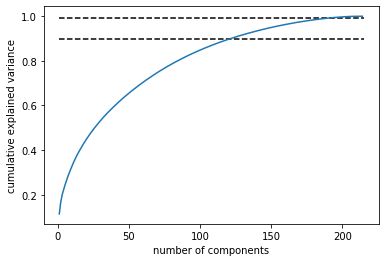

In [0]:
df_scaled = scaler.fit_transform(df.drop(['class'],axis=1))
p = df_scaled.shape[-1]
pca = PCA(n_components=p)
pca.fit(df_scaled)
cumulative_explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, p + 1), cumulative_explained_var)
plt.hlines(0.9, 1, p+1, linestyles='--')
plt.hlines(0.99, 1, p+1, linestyles='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

- Try clustering the data to see if the malware instances cluster together.

In [0]:
from sklearn.cluster import (
    KMeans, 
    AgglomerativeClustering
)

from sklearn.metrics import (
    homogeneity_score,
    completeness_score,
    v_measure_score
)
kmeans = KMeans(n_clusters=2).fit(
    df.drop(['class'],axis=1)
)
print(kmeans.cluster_centers_)
df['cluster'] = kmeans.labels_
print(df.groupby(['cluster', 'class']).size().reset_index().sort_values(['cluster', 'class']))

predicted_clusters = df['cluster'].values
true_labels = df['class'].values
print(homogeneity_score(true_labels, predicted_clusters))
print(completeness_score(true_labels, predicted_clusters))
print(v_measure_score(true_labels, predicted_clusters))


agg = AgglomerativeClustering(n_clusters=2).fit(
    df.drop(['class'],axis=1)
)

df['cluster'] = agg.labels_
print(df.groupby(['cluster', 'class']).size().reset_index().sort_values(['cluster', 'class']))

predicted_clusters = df['cluster'].values
true_labels = df['class'].values
print(homogeneity_score(true_labels, predicted_clusters))
print(completeness_score(true_labels, predicted_clusters))
print(v_measure_score(true_labels, predicted_clusters))


[[1.16171840e-01 1.34390463e-01 1.30004498e-01 1.15272155e-01
  1.32928475e-01 1.90058480e-01 3.30859199e-01 3.38506523e-02
  2.23796671e-02 4.04858300e-02 1.15834458e-01 7.07377418e-02
  2.41115610e-01 6.33378318e-01 1.54071075e-02 2.41452991e-01
  2.34480432e-01 1.48335583e-01 1.76900585e-01 1.04251012e-01
  2.36729645e-01 1.84435448e-01 2.29082321e-01 1.70940171e-02
  1.52721547e-01 4.63000450e-01 2.72154746e-02 2.28295097e-02
  4.50179937e-01 1.93544759e-01 2.52923977e-01 4.14979757e-02
  2.70692758e-01 1.87809267e-01 3.19725596e-01 1.95569051e-01
  3.45254161e-02 1.78025191e-01 1.30229420e-01 2.86774629e-02
  1.16959064e-02 6.01664417e-02 1.01214575e-01 2.10301395e-01
  3.72132254e-01 9.09806568e-02 1.96131354e-01 5.46558704e-02
  5.42510121e-01 2.38416554e-02 1.13135403e-01 3.76180837e-01
  7.85087719e-01 2.14799820e-02 6.47548358e-01 1.02339181e-02
  3.84615385e-02 6.39338731e-01 6.39338731e-01 3.41880342e-02
  1.18083671e-02 5.30814215e-02 1.15834458e-02 6.44399460e-02
  1.1021

##Visualization


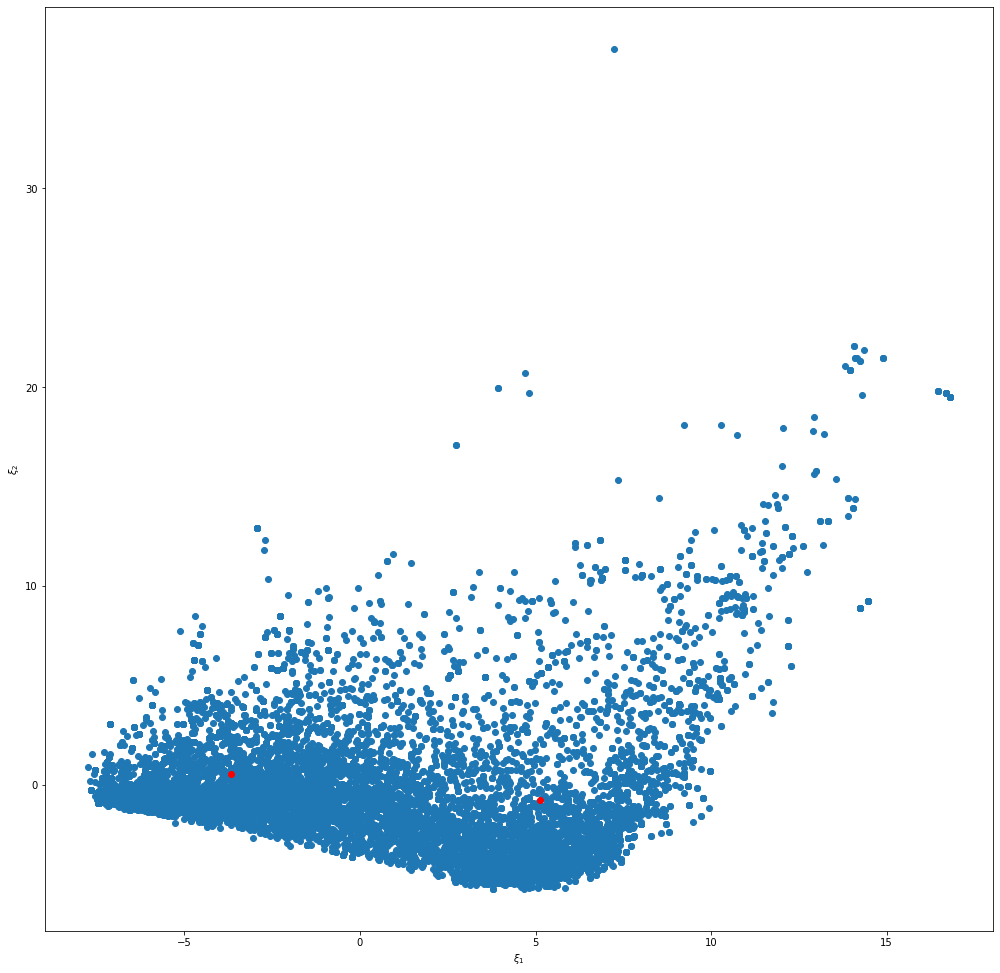

In [0]:
from sklearn.pipeline import Pipeline
pca = PCA(n_components=2)
pipe = Pipeline([('scaler', StandardScaler()), ('dim-red', pca)])
Xt = pipe.fit_transform(df.drop(['class'],axis=1))
kmeans = KMeans(n_clusters=2).fit(
    Xt
)


fig, ax = plt.subplots(figsize=(17, 17))
ax.scatter(*Xt.T)
ax.scatter(*kmeans.cluster_centers_.T,c='red')
ax.set_xlabel('$\\xi_1$')
ax.set_ylabel('$\\xi_2$')
plt.show()



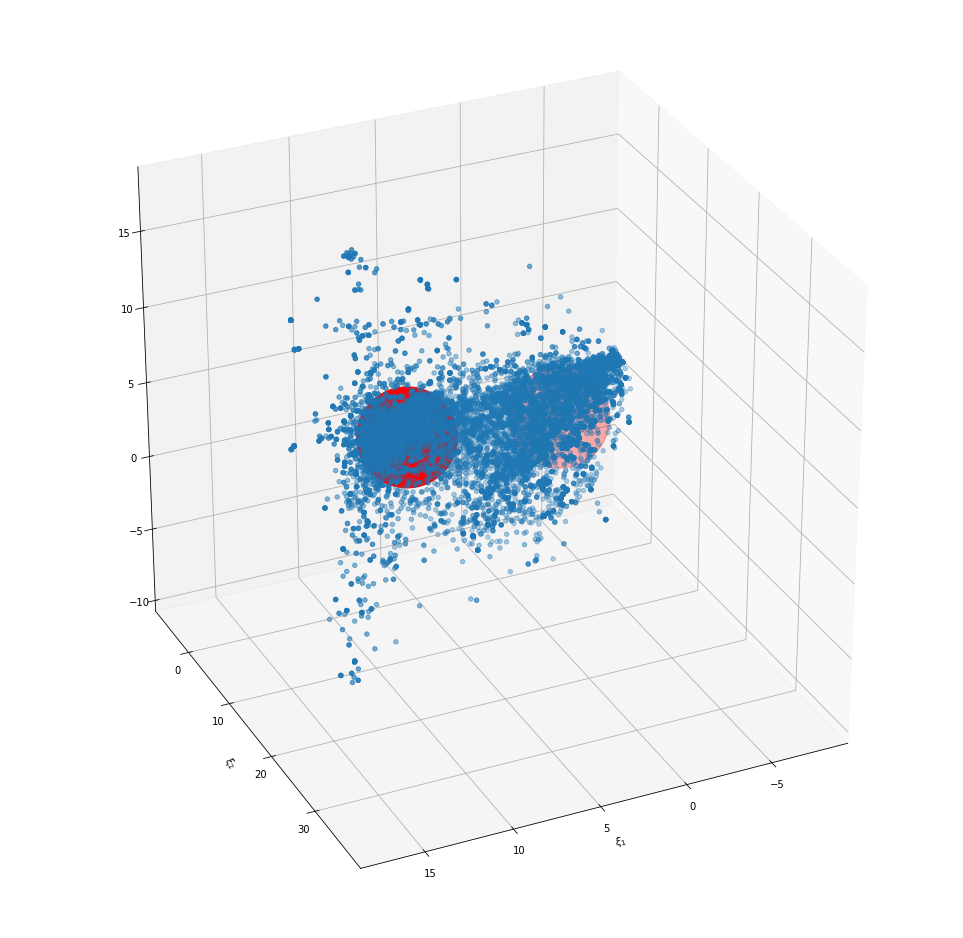

In [0]:
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.pipeline import Pipeline
pca = PCA(n_components=3)
pipe = Pipeline([('scaler', StandardScaler()), ('dim-red', pca)])
Xt = pipe.fit_transform(df.drop(['class'],axis=1))
kmeans = KMeans(n_clusters=2).fit(
    Xt
)


fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot( projection='3d')
ax.scatter(*Xt.T)
ax.scatter(*kmeans.cluster_centers_.T,c='red',s=10200)
ax.set_xlabel('$\\xi_1$')
ax.set_ylabel('$\\xi_2$')
ax.view_init(30,65)
plt.show()

    
    

#*Sara Imbeni*

# *Giacomo Minello*

# *Utkan Peker*